In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import shutil
from tensorflow import keras
import seaborn as sns
import random
import splitfolders
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import InceptionV3

In [2]:
acrima_dir = "ACRIMA"
glaucoma_dir = acrima_dir + "/1_glaucoma"
normal_dir = acrima_dir + "/0_normal"

normal_images = os.listdir(normal_dir)
glaucoma_images = os.listdir(glaucoma_dir)

# Look at the number of samples in each dataset
print("Acrima dataset contains : ")
print(f"\t{len(glaucoma_images)} images representing an eye with glaucoma")
print(f"\t{len(normal_images)} images representing a normal eye")

Acrima dataset contains : 
	396 images representing an eye with glaucoma
	309 images representing a normal eye


Total images: 705
Total number of classes: 2
Total glaucoma images: 396
Total normal images: 309


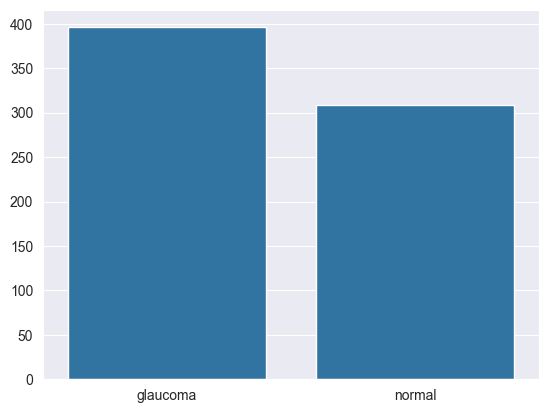

In [3]:
base_dir = 'ACRIMA'
base_dir = pathlib.Path(base_dir)

glaucoma = [fn for fn in os.listdir(f'ACRIMA/1_glaucoma')]
normal = [fn for fn in os.listdir(f'ACRIMA/0_normal')]
data=[glaucoma,normal]
dataset_classes =['glaucoma','normal']

image_count = len(list(base_dir.glob('*/*.jpg')))+len(list(base_dir.glob('*/*.png')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(dataset_classes)}')
count = 0
data_count = []
for x in dataset_classes:
  print(f'Total {x} images: {len(data[count])}')
  data_count.append(len(data[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=dataset_classes, y=data_count)
plt.show()

In [4]:
base_ds = 'ACRIMA'
base_ds = pathlib.Path(base_ds)
img_height=256
img_width=256
batch_size=32
splitfolders.ratio(base_ds, output='images', seed=1321, ratio=(.8,.1,.1), group_prefix=None)

In [5]:
datagen = ImageDataGenerator(rescale=1./255,
shear_range = 0.15,
zoom_range = 0.15,
horizontal_flip = True)
train_ds = datagen.flow_from_directory(
    'images/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

val_ds = datagen.flow_from_directory(
    'images/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'images/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 563 images belonging to 2 classes.


Found 69 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [6]:
print(train_ds.class_indices)


{'0_normal': 0, '1_glaucoma': 1}


In [9]:
# Load the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers on top of the InceptionV3 base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(train_ds, epochs=150, validation_data=val_ds)

Epoch 1/150
18/18 [==============================] - 9s 399ms/step - loss: 2.5363 - accuracy: 0.3996 - val_loss: 0.6540 - val_accuracy: 0.5652
Epoch 2/150
18/18 [==============================] - 6s 316ms/step - loss: 0.6630 - accuracy: 0.6252 - val_loss: 0.5979 - val_accuracy: 0.7391
Epoch 3/150
18/18 [==============================] - 6s 311ms/step - loss: 0.5418 - accuracy: 0.7655 - val_loss: 0.5841 - val_accuracy: 0.7246
Epoch 4/150
18/18 [==============================] - 6s 313ms/step - loss: 0.5424 - accuracy: 0.7389 - val_loss: 0.5827 - val_accuracy: 0.6957
Epoch 5/150
18/18 [==============================] - 6s 313ms/step - loss: 0.6068 - accuracy: 0.6750 - val_loss: 0.5321 - val_accuracy: 0.7681
Epoch 6/150
18/18 [==============================] - 6s 317ms/step - loss: 0.5081 - accuracy: 0.7815 - val_loss: 0.4960 - val_accuracy: 0.7246
Epoch 7/150
18/18 [==============================] - 6s 320ms/step - loss: 0.4344 - accuracy: 0.8259 - val_loss: 0.4600 - val_accuracy: 0.7681

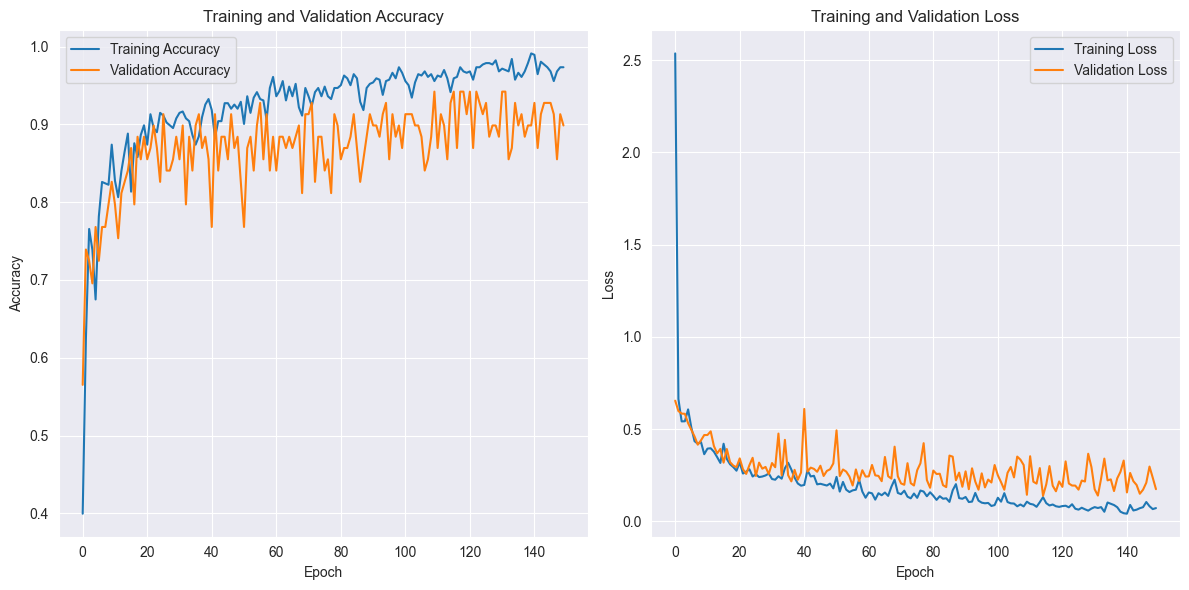

In [10]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
score= model.evaluate(test_ds)
print("Loss:",score[0],"Accuracy:",score[1])

3/3 [==============================] - 1s 169ms/step - loss: 0.0817 - accuracy: 0.9863
Loss: 0.08172513544559479 Accuracy: 0.9863013625144958


In [18]:
model.save('glaucoma_detection.h5')

C:\Users\Sid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 167ms/step


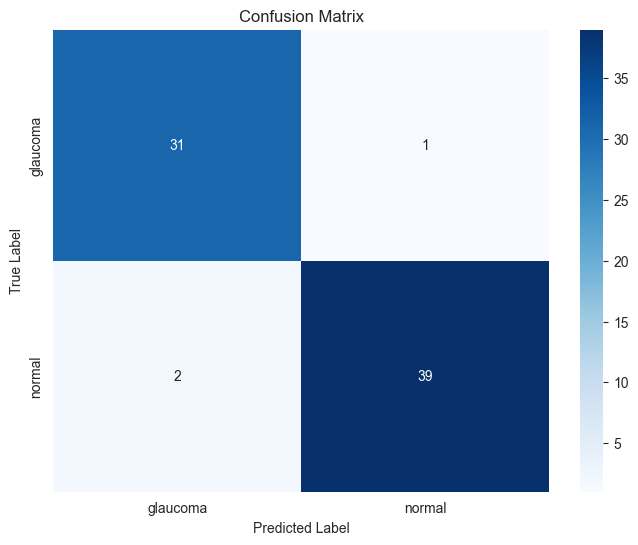

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions on the test set
predictions = model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_ds.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset_classes, yticklabels=dataset_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


3/3 [==============================] - 1s 167ms/step


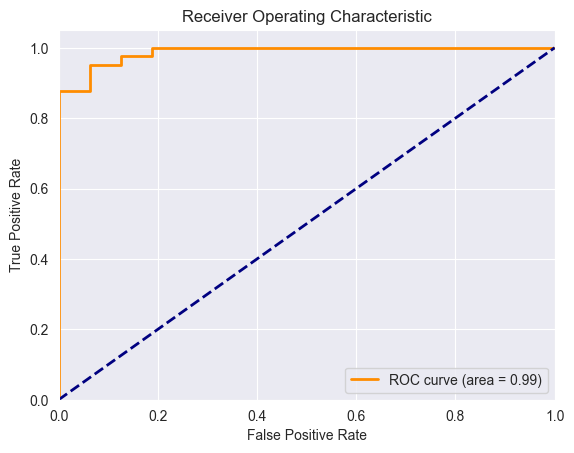

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image
import numpy as np

# Assuming your model and test_ds (test dataset) are already defined and you have a trained model

# First, predict probabilities for the test dataset
# Make sure test_ds does not shuffle data to match predictions with their actual labels
test_ds.reset() # Reset the test dataset iterator
predictions = model.predict(test_ds, steps=len(test_ds), verbose=1)

# Since your model outputs probabilities for both classes, take the probability of the class of interest (e.g., glaucoma)
# Assuming glaucoma is the positive class and its index is 1
y_pred = predictions[:, 1]

# Get the actual labels from the test dataset
y_true = test_ds.classes

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
